In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
alphabet = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"," ","."]

with open('data/sample/ciphertext.txt', 'r', encoding='utf-8') as f:
    ciphertext = f.read()

with open('data/sample/plaintext.txt', 'r', encoding='utf-8') as f:
    plaintext = f.read()

P = np.loadtxt("data/letter_probabilities.csv", delimiter = ",")
M = np.loadtxt("data/letter_transition_matrix.csv", delimiter = ",")

inverse_perm = {c: i for i, c in enumerate(permutation)}
print(inverse_perm)


# r to m

NameError: name 'permutation' is not defined

In [3]:
#MH MCMC Algorithm
def log_likelihood(perm, txt):
    inverse_perm = {c: i for i, c in enumerate(perm)}

    log_lik = 0

    for i, char in enumerate(txt):
        decoded_char_idx = inverse_perm[char]

        if i == 0:
            log_lik += np.log(P[decoded_char_idx])

        else:
            prev_decoded_char_idx = inverse_perm[txt[i-1]]

            if M[decoded_char_idx][prev_decoded_char_idx] == 0:
                return float('-inf')

            log_lik += np.log(M[decoded_char_idx][prev_decoded_char_idx])

    return log_lik

def propose_new_permutation(perm):
    i, j = random.sample(range(len(perm)), 2)
    new_perm = perm.copy()
    new_perm[i], new_perm[j] = new_perm[j], new_perm[i]
    return new_perm


def MH(T):
    permutation = random.sample(alphabet, len(alphabet))
    f_star = permutation
    L_star = log_likelihood(permutation, ciphertext)

    f_prev = permutation

    for i in range(T):
        fprime = propose_new_permutation(f_prev)

        old_ll = log_likelihood(f_prev, ciphertext)
        new_ll = log_likelihood(fprime, ciphertext)

        if old_ll == float('-inf'):
            bernoulli_param = 1
        else:
            bernoulli_param = min(1, np.exp(new_ll-old_ll))

        if random.random() < bernoulli_param:

            if new_ll > L_star:
                L_star = new_ll
                f_star = fprime

            f_prev = fprime

    return L_star, f_star
    

In [ ]:
import numpy as np, random, math

K = len(alphabet)
char2idx = {c:i for i,c in enumerate(alphabet)}
C = np.array([char2idx[c] for c in ciphertext], dtype=int)

eps  = 1e-8
P_s  = P + eps;      P_s /= P_s.sum()
M_s  = M + eps;      M_s /= M_s.sum(axis=0, keepdims=True)
logP = np.log(P_s)
logM = np.log(M_s)

def log_likelihood(perm, C):
    D = perm[C]
    return logP[D[0]] + logM[D[1:], D[:-1]].sum()

def propose(perm):
    # swap two *distinct* indices
    i, j = random.sample(range(K), 2)
    perm2 = perm.copy()
    perm2[i], perm2[j] = perm2[j], perm2[i]
    return perm2

def MH_good(T):
    perm     = np.random.permutation(K)
    ll_prev  = log_likelihood(perm, C)
    best     = perm.copy()
    best_ll  = ll_prev

    for _ in range(T):
        cand    = propose(perm)
        ll_cand = log_likelihood(cand, C)

        # decode *current* perm by indexing through C
        decoded = "".join(alphabet[perm[idx]] for idx in C)

        # compute acceptance probability (overflow‐safe)
        diff  = ll_cand - ll_prev
        alpha = 1.0 if diff >= 0 else math.exp(diff)

        if random.random() < alpha: # accept new perm
            perm, ll_prev = cand, ll_cand
            # update best if improved
            if ll_cand > best_ll:
                best_ll, best = ll_cand, cand.copy()


    return best_ll, best



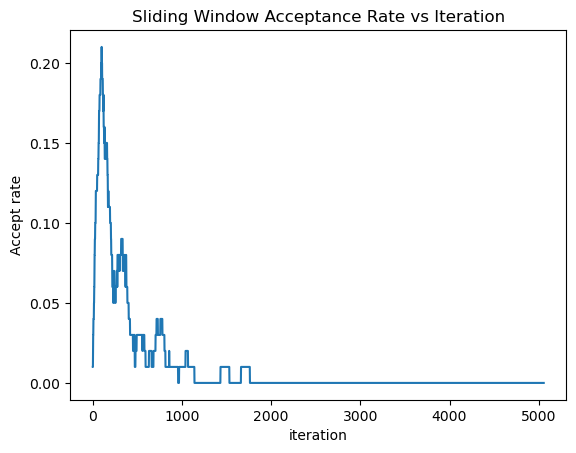

In [186]:
_,_,p,a,d = MH_good(5000)

plt.figure()
plt.plot(p)   # add markers if you like
plt.xlabel('iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of Accepted State vs Iteration')

plt.show()

def accept_rate(a, w):
    a = np.asarray(a, dtype=float)
    csum = np.cumsum(a)
    # For i < w: just csum[i]
    # For i ≥ w: csum[i] - csum[i-w]
    out = np.empty_like(csum)
    out[:w] = csum[:w]
    out[w:] = csum[w:] - csum[:-w]
    return out/w

window = accept_rate(a, 100)

plt.figure()
plt.plot(window)   # add markers if you like
plt.xlabel('iteration')
plt.ylabel('Accept rate')
plt.title('Sliding Window Acceptance Rate vs Iteration')

plt.show()

plt.figure()
plt.plot([i/len(plaintext) for i in d])   # add markers if you like
plt.xlabel('iteration')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy vs Iteration')

plt.show()